# ⚽ Premier League & Champions League Predictor (v5.0)

Este notebook implementa um sistema de Machine Learning para prever resultados de futebol.
O sistema utiliza:
1. **XGBoost** (Classificação Multi-classe e Binária)
2. **Expected Goals (xG)** extraídos do Understat.
3. **Elo Ratings** dinâmicos calculados jogo-a-jogo.
4. **Valores de Mercado** históricos do Transfermarkt.

**Objetivo:** Maximizar a precisão e detetar "Value Bets" contra as casas de apostas.

Imports e Configuração

In [1]:
# --- IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import os
import warnings

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix
from bs4 import BeautifulSoup

# --- AS TUAS FUNÇÕES PERSONALIZADAS ---
# (Certifica-te que o ficheiro data_utils.py está na mesma pasta)
from data_utils import clean_team_name, scrape_understat_season, get_main_data, prepare_market_values, get_understat_data

from scipy.stats import poisson

# --- CONFIGURAÇÃO ---
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

DATA_FILE = 'europe_football_full.csv' 
XG_FILE = 'europe_football_xg.csv'
MARKET_VALUE_FILE = 'market_values.csv'
START_YEAR = 2014 
END_YEAR = 2025

## 1. Aquisição e Processamento de Dados (ETL)
Nesta etapa carregamos os dados das ligas, xG e valores de mercado. Se os ficheiros não existirem, o sistema faz o download/scraping automaticamente.

In [2]:
import requests
import re

print("🕵️ TESTE DE DIAGNÓSTICO UNDERSTAT")
url = "https://understat.com/league/EPL/2023"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8',
}

try:
    print(f"1. A tentar conectar a {url}...")
    response = requests.get(url, headers=headers, timeout=10)
    print(f"2. Código de Estado: {response.status_code}")
    
    if response.status_code == 200:
        print("3. Conexão bem sucedida! A procurar dados...")
        match = re.search(r"datesData\s*=\s*JSON\.parse\('(.*?)'\)", response.text)
        if match:
            print("✅ SUCESSO! Dados JSON encontrados. O scraping devia estar a funcionar.")
            print(f"   Tamanho dos dados: {len(match.group(1))} caracteres")
        else:
            print("❌ ERRO: Página carregou, mas não encontrei o padrão 'datesData'. O site pode ter mudado o layout.")
            # Debug: Mostrar um pedaço do HTML para ver se é uma página de bloqueio
            print(f"   Conteúdo recebido (primeiros 500 chars): {response.text[:500]}")
    elif response.status_code == 403:
        print("⛔ BLOQUEADO (Erro 403). O site detetou que és um script.")
    elif response.status_code == 429:
        print("⏳ BLOQUEADO (Erro 429). Demasiados pedidos. Tens de esperar.")
    else:
        print(f"⚠️ Erro desconhecido: {response.status_code}")
        
except Exception as e:
    print(f"💥 Erro Crítico: {e}")

🕵️ TESTE DE DIAGNÓSTICO UNDERSTAT
1. A tentar conectar a https://understat.com/league/EPL/2023...
2. Código de Estado: 200
3. Conexão bem sucedida! A procurar dados...
❌ ERRO: Página carregou, mas não encontrei o padrão 'datesData'. O site pode ter mudado o layout.
   Conteúdo recebido (primeiros 500 chars): <!DOCTYPE html>
<html lang="en">
    <head>
		<base href="https://understat.com/">
		<title>EPL xG Table and Scorers for the 2023/2024 season | Understat.com</title>
        <meta charset="UTF-8" />
		<meta name="description" content="xG table of EPL standings and top scorers for the 2023/2024 season, also tables from past seasons and other European football leagues.">
		<meta name="Keywords" content="EPL, xg table,scorers, expected goals table, season 2023/2024">
		<meta name="viewport" user-sc


In [3]:
import requests
from bs4 import BeautifulSoup

print("🩻 RAIO-X À PÁGINA UNDERSTAT")
url = "https://understat.com/league/EPL/2023"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
}

try:
    response = requests.get(url, headers=headers, timeout=15)
    soup = BeautifulSoup(response.content, 'html.parser')
    scripts = soup.find_all('script')
    
    print(f"📄 Encontrei {len(scripts)} scripts. A filtrar os 'pesados' (> 1000 chars)...")
    
    found_big_data = False
    for i, script in enumerate(scripts):
        if script.string:
            content = script.string.strip()
            size = len(content)
            
            # Se o script for grande, provavelmente contém os dados que queremos
            if size > 1000:
                found_big_data = True
                print(f"\n📦 [SCRIPT #{i}] Tamanho: {size} caracteres")
                print(f"   🔎 Início do conteúdo (primeiros 100 chars):")
                print(f"   👉 {content[:100]}...")
                
                # Verificar se contém palavras-chave
                if "h" in content and "a" in content and "goals" in content:
                    print("   ✅ PALAVRAS-CHAVE DETETADAS: Este parece ser o script dos jogos!")
                
    if not found_big_data:
        print("\n❌ ALERTA: Nenhum script grande encontrado. O site pode estar a carregar dados via API (oculta) ou estás a receber uma versão 'lite' da página.")

except Exception as e:
    print(f"💥 Erro: {e}")

🩻 RAIO-X À PÁGINA UNDERSTAT
📄 Encontrei 27 scripts. A filtrar os 'pesados' (> 1000 chars)...

📦 [SCRIPT #3] Tamanho: 1101 caracteres
   🔎 Início do conteúdo (primeiros 100 chars):
   👉 /*
		var flagFontsLoading = false;
		WebFont.load({
			google: {
				families: ['Barlow:500', 'Anton...


In [4]:
# 1. Preparar Valores de Mercado (Transfermarkt)
prepare_market_values()

# 2. Carregar Dados das Ligas (Football-Data)
df_main = get_main_data(START_YEAR, END_YEAR)

# 3. Carregar/Scrapar xG (Understat)
# Agora é só uma linha! A função gere o ficheiro e o download sozinha.
df_understat = get_understat_data(START_YEAR, END_YEAR)

# 4. MERGE FINAL (Ligas + xG + Champions)
if not df_understat.empty:
    df_understat['Date'] = pd.to_datetime(df_understat['Date']).dt.normalize()
    df_main['Date'] = df_main['Date'].dt.normalize()
    
    # Separar Ligas vs Champions
    df_leagues = df_understat[df_understat['League'] != 'Champions_League']
    df_cl = df_understat[df_understat['League'] == 'Champions_League'].copy()
    df_cl['Div'] = 'CL'
    
    # Calcular FTR para a Champions (Understat não tem FTR explícito)
    df_cl['FTR'] = df_cl.apply(lambda r: 'H' if r['FTHG'] > r['FTAG'] else ('A' if r['FTHG'] < r['FTAG'] else 'D'), axis=1)
    
    # Preparar colunas comuns
    cols_common = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'Div', 'Home_xG', 'Away_xG']
    df_cl_clean = df_cl[cols_common]
    
    # Merge nas Ligas
    print("🔄 A realizar Merge (Ligas)...")
    cols_exclude = [c for c in df_main.columns if 'xG' in c]
    df_main = df_main.drop(columns=cols_exclude)
    
    df_final = df_main.merge(
        df_leagues[['Date', 'HomeTeam', 'AwayTeam', 'Home_xG', 'Away_xG']],
        on=['Date', 'HomeTeam', 'AwayTeam'],
        how='left'
    )
    
    # Adicionar Champions (Append)
    print(f"🇪🇺 A adicionar {len(df_cl_clean)} jogos da Champions League...")
    df_final = pd.concat([df_final, df_cl_clean], ignore_index=True)
else:
    df_final = df_main.copy()

# Ordenação Cronológica e Limpeza Final
hoje = pd.Timestamp.now().normalize()
df_final = df_final[df_final['Date'] <= hoje]
df = df_final.sort_values(['Date']).reset_index(drop=True)
df = df.fillna({'Home_xG': 1.0, 'Away_xG': 1.0})

print(f"✅ Total Jogos Processados: {len(df)}")
display(df.tail(3))

📂 Carregando dados locais: market_values.csv
📂 Carregando dados locais: europe_football_full.csv
📂 Carregando dados Understat locais: europe_football_xg.csv
🔄 A realizar Merge (Ligas)...
🇪🇺 A adicionar 0 jogos da Champions League...
✅ Total Jogos Processados: 63002


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BVCD,BVCA,CLCH,CLCD,CLCA,LBCH,LBCD,LBCA,Home_xG,Away_xG
62999,E1,2025-12-10,Derby,Millwall,1.0,1.0,D,0.0,0.0,D,...,3.0,2.75,2.6,3.1,2.8,2.60,3.1,2.80,1.0,1.0
63000,E1,2025-12-10,Hull City,Wrexham,2.0,0.0,H,1.0,0.0,H,...,3.4,2.75,2.4,3.4,2.9,2.37,3.4,2.87,1.0,1.0
63001,E1,2025-12-10,Ipswich,Stoke City,1.0,0.0,H,1.0,0.0,H,...,3.9,6.50,1.6,3.9,5.5,1.60,3.9,5.50,1.0,1.0


## 2. Feature Engineering
Criação de métricas avançadas:
* **Elo Ratings:** Atualizados a cada partida.
* **Rolling Stats:** Médias móveis de xG e Golos (últimos 5 jogos).
* **Fadiga:** Jogos com menos de 4 dias de descanso.

In [5]:
def feature_engineering(df):
    print("⚙️ Gerando Features AVANÇADAS (Ligas + CL + Disciplina + Intervalo + FORMA + DATA_QUALITY)...")
    df = df.copy()
    
    # 1. PREPARAÇÃO BÁSICA
    df['Season'] = df['Date'].apply(lambda x: x.year if x.month > 7 else x.year - 1).astype(int)
    df = df.sort_values('Date')
    
    le_div = LabelEncoder()
    df['Div_Code'] = le_div.fit_transform(df['Div'])
    
    # ---------------------------------------------------------
    # 2. MARKET VALUE & CONTEXTO
    # ---------------------------------------------------------
    real_values = {}
    if os.path.exists('market_values.csv'):
        try:
            mv_df = pd.read_csv('market_values.csv')
            mv_df.columns = [c.strip().capitalize() for c in mv_df.columns] 
            if 'Year' in mv_df.columns: mv_df.rename(columns={'Year': 'Season'}, inplace=True)
            for _, row in mv_df.iterrows():
                try: 
                    s = int(row['Season'])
                    t = row['Team']
                    if s not in real_values: real_values[s] = {}
                    real_values[s][t] = row['Value']
                except: continue
        except: pass

    def get_market_value(team, season):
        if season in real_values and team in real_values[season]:
            return real_values[season][team]
        tier_1 = ['Man City', 'Arsenal', 'Liverpool', 'Real Madrid', 'Barcelona', 'Bayern Munich', 'Paris Saint Germain', 'Inter']
        if team in tier_1: return 900
        return 200

    df['Home_Value'] = df.apply(lambda x: get_market_value(x['HomeTeam'], x['Season']), axis=1)
    df['Away_Value'] = df.apply(lambda x: get_market_value(x['AwayTeam'], x['Season']), axis=1)
    df['Value_Ratio'] = np.log1p(df['Home_Value']) - np.log1p(df['Away_Value'])

    # ---------------------------------------------------------
    # 3. PONTOS, POSIÇÃO E MOTIVAÇÃO
    # ---------------------------------------------------------
    standings = {} 
    df['Home_Pts'] = 0; df['Away_Pts'] = 0
    df['Home_Pos'] = 10; df['Away_Pos'] = 10
    
    df['Is_Cup'] = df['Div'].apply(lambda x: 1 if x == 'CL' else 0)

    for i, row in df.iterrows():
        season = row['Season']; div = row['Div']
        h, a, res = row['HomeTeam'], row['AwayTeam'], row['FTR']
        
        if season not in standings: standings[season] = {}
        if div not in standings[season]: standings[season][div] = {}
        if h not in standings[season][div]: standings[season][div][h] = {'pts': 0, 'games': 0}
        if a not in standings[season][div]: standings[season][div][a] = {'pts': 0, 'games': 0}
        
        df.at[i, 'Home_Pts'] = standings[season][div][h]['pts']
        df.at[i, 'Away_Pts'] = standings[season][div][a]['pts']
        
        if div != 'CL':
            teams_sorted = sorted(standings[season][div].items(), key=lambda x: x[1]['pts'], reverse=True)
            ranks = {t: r+1 for r, (t, data) in enumerate(teams_sorted)}
            df.at[i, 'Home_Pos'] = ranks.get(h, 10)
            df.at[i, 'Away_Pos'] = ranks.get(a, 10)
        else:
            df.at[i, 'Home_Pos'] = 1
            df.at[i, 'Away_Pos'] = 1

        pts_h = 3 if res == 'H' else 1 if res == 'D' else 0
        pts_a = 3 if res == 'A' else 1 if res == 'D' else 0
        standings[season][div][h]['pts'] += pts_h
        standings[season][div][a]['pts'] += pts_a
        standings[season][div][h]['games'] += 1
        standings[season][div][a]['games'] += 1

    df['Home_Motiv'] = np.where(df['Is_Cup']==1, 1.3, np.where(df['Home_Pos']<=6, 1.2, 1.0))
    df['Away_Motiv'] = np.where(df['Is_Cup']==1, 1.3, np.where(df['Away_Pos']<=6, 1.2, 1.0))

    # ---------------------------------------------------------
    # 4. ROLLING STATS (COM FORMA E CONVERSÃO)
    # ---------------------------------------------------------
    stats_targets = [
        'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 
        'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'Home_xG', 'Away_xG'
    ]
    valid_stats = [c for c in stats_targets if c in df.columns]
    
    # Preparar mapeamento
    stat_pairs = [
        ('FTHG', 'FTAG', 'Goals_Scored'),
        ('FTAG', 'FTHG', 'Goals_Conceded'),
        ('HTHG', 'HTAG', 'HalfTime_Goals_Scored'),
        ('HS', 'AS', 'Shots'),
        ('HST', 'AST', 'Shots_Target'),
        ('HC', 'AC', 'Corners'),
        ('HF', 'AF', 'Fouls'),
        ('HY', 'AY', 'YellowCards'),
        ('HR', 'AR', 'RedCards'),
        ('Home_xG', 'Away_xG', 'xG_For'),
        ('Away_xG', 'Home_xG', 'xG_Against')
    ]
    
    long_stats = []
    for _, row in df.iterrows():
        rec_h = {'Date': row['Date'], 'Team': row['HomeTeam']}
        rec_a = {'Date': row['Date'], 'Team': row['AwayTeam']}
        
        # 1. Stats Normais
        for col_h, col_a, name in stat_pairs:
            if col_h in df.columns and col_a in df.columns:
                rec_h[name] = row[col_h]
                rec_a[name] = row[col_a]
        
        # 2. CALCULAR PONTOS (NOVO!)
        res = row['FTR']
        pts_h = 3 if res == 'H' else (1 if res == 'D' else 0)
        pts_a = 3 if res == 'A' else (1 if res == 'D' else 0)
        rec_h['Points'] = pts_h
        rec_a['Points'] = pts_a
        
        long_stats.append(rec_h)
        long_stats.append(rec_a)
        
    df_long = pd.DataFrame(long_stats).sort_values(['Team', 'Date'])
    
    # Calcular Rolling Averages
    cols_to_roll = [c for c in df_long.columns if c not in ['Date', 'Team']]
    
    for col in cols_to_roll:
        df_long[f'Avg_{col}_5'] = df_long.groupby('Team')[col].transform(lambda x: x.shift(1).rolling(5, min_periods=3).mean()).fillna(0)
        
    # --- FEATURES COMPOSTAS (Fora do Loop) ---
    # Precisão (Remates à baliza / Total)
    if 'Shots' in cols_to_roll and 'Shots_Target' in cols_to_roll:
         df_long['Avg_Accuracy_5'] = np.where(df_long['Avg_Shots_5']>0, df_long['Avg_Shots_Target_5']/df_long['Avg_Shots_5'], 0)

    # Conversão (Golos / Remates à baliza) - NOVO!
    if 'Goals_Scored' in cols_to_roll and 'Shots_Target' in cols_to_roll:
         df_long['Avg_Conversion_5'] = np.where(df_long['Avg_Shots_Target_5']>0, df_long['Avg_Goals_Scored_5']/df_long['Avg_Shots_Target_5'], 0)

    # ---------------------------------------------------------
    # 5. MERGE FINAL
    # ---------------------------------------------------------
    cols_calculated = ['Date', 'Team'] + [c for c in df_long.columns if 'Avg_' in c]
    
    df = df.merge(df_long[cols_calculated], left_on=['Date', 'HomeTeam'], right_on=['Date', 'Team'], how='left').drop(columns=['Team'])
    rename_dict_h = {c: f"Home_{c}" for c in cols_calculated if c not in ['Date', 'Team']}
    df.rename(columns=rename_dict_h, inplace=True)
    
    df = df.merge(df_long[cols_calculated], left_on=['Date', 'AwayTeam'], right_on=['Date', 'Team'], how='left').drop(columns=['Team'])
    rename_dict_a = {c: f"Away_{c}" for c in cols_calculated if c not in ['Date', 'Team']}
    df.rename(columns=rename_dict_a, inplace=True)

    # ---------------------------------------------------------
    # 6. ELO E LIMPEZA
    # ---------------------------------------------------------
    df['Rest_Home'] = df.groupby('HomeTeam')['Date'].diff().dt.days.fillna(7).clip(upper=15)
    df['Rest_Away'] = df.groupby('AwayTeam')['Date'].diff().dt.days.fillna(7).clip(upper=15)
    
    df['HomeElo'] = 1500; df['AwayElo'] = 1500
    elo_dict = {}
    for i, row in df.iterrows():
        h, a, res = row['HomeTeam'], row['AwayTeam'], row['FTR']
        h_elo = elo_dict.get(h, 1500); a_elo = elo_dict.get(a, 1500)
        df.at[i, 'HomeElo'] = h_elo; df.at[i, 'AwayElo'] = a_elo
        
        actual = 1 if res == 'H' else 0.5 if res == 'D' else 0
        exp = 1 / (1 + 10**((a_elo - h_elo)/400))
        elo_dict[h] = h_elo + 20 * (actual - exp)
        elo_dict[a] = a_elo - 20 * (actual - exp)
    
    df['EloDiff'] = df['HomeElo'] - df['AwayElo']

    if 'B365H' in df.columns:
        df['Imp_Home'] = 1/df['B365H']
        df['Imp_Draw'] = 1/df['B365D']
        df['Imp_Away'] = 1/df['B365A']
    else:
        df['Imp_Home'] = 0; df['Imp_Draw'] = 0; df['Imp_Away'] = 0

    # --- NOVA LÓGICA DE QUALIDADE DOS DADOS (Has_xG_Data) ---
    # Ensinar o modelo que jogos da 2ª divisão ou ligas periféricas não têm xG real
    understat_leagues = ['E0', 'D1', 'SP1', 'F1', 'I1', 'CL'] # Ligas que têm xG no Understat
    df['Has_xG_Data'] = df['Div'].apply(lambda x: 1 if x in understat_leagues else 0)
    df['Home_Adj_Form'] = df['Home_Avg_Points_5'] * (df['HomeElo'] / 1000)
    df['Away_Adj_Form'] = df['Away_Avg_Points_5'] * (df['AwayElo'] / 1000)

    # DEFINIÇÃO FINAL DAS FEATURES (Removidas as que tinham 0% importância)
    features = [
        'Div_Code', 
        'EloDiff', 'HomeElo', 'AwayElo',
        'Home_Value', 'Away_Value', 'Value_Ratio',
        'Home_Motiv', # Mantivemos Home_Motiv, removemos Away_Motiv (ruído)
        'Rest_Home', 'Rest_Away',
        'Imp_Home', 'Imp_Draw', 'Imp_Away',
        'Home_Pos', 'Away_Pos', 'Home_Pts', 'Away_Pts',
        'Home_Adj_Form', 'Away_Adj_Form' # <--- Novas features
    ]
    # Adicionar as médias móveis (Stats de jogo)
    features += [c for c in df.columns if 'Home_Avg_' in c or 'Away_Avg_' in c]
    
    # Remover duplicados e garantir que existem no DF
    features = list(set([f for f in features if f in df.columns]))
    
    df_clean = df.dropna(subset=['FTR']).copy()
    
    # Filtro de segurança: Remover jogos com Odds estranhas (erros de dados)
    if 'Imp_Home' in df_clean.columns:
        df_clean = df_clean[(df_clean['Imp_Home'] > 0) & (df_clean['Imp_Home'] < 0.98)]
        
    df_clean[features] = df_clean[features].fillna(0)
    
    return df_clean, features, elo_dict, le_div

In [6]:
# Executar a engenharia de features
df_ready, features, current_elos, le_div = feature_engineering(df)
print(f"✅ Features updated. Total features: {len(features)}")

⚙️ Gerando Features AVANÇADAS (Ligas + CL + Disciplina + Intervalo + FORMA + DATA_QUALITY)...
✅ Features updated. Total features: 47


## 3. Treino do Modelo (XGBoost)
Utilizamos `GridSearchCV` com `TimeSeriesSplit` para garantir que o modelo não aprende com o futuro.
* **Modelo Multi:** Prevê Probabilidades (Home, Draw, Away).
* **Modelo Sniper:** Binário, focado apenas na vitória da casa.
* **Modelo Shield:** Binário, focado em evitar a derrota (1X).

In [7]:
# --- 0. LIMPEZA DE SEGURANÇA (CRÍTICO) ---
# Isto resolve o erro "Input data contains inf"
print("🧹 A limpar valores infinitos e nulos...")
df_ready.replace([np.inf, -np.inf], 0, inplace=True)
df_ready.fillna(0, inplace=True)

# 1. Preparar Target
le = LabelEncoder()
df_ready['Target'] = le.fit_transform(df_ready['FTR']) # 0=Away, 1=Draw, 2=Home

# 2. Split Cronológico (80/20)
split_index = int(len(df_ready) * 0.80)
train = df_ready.iloc[:split_index]
test = df_ready.iloc[split_index:]

X_train, y_train = train[features], train['Target']
X_test, y_test = test[features], test['Target']

print(f"🏋️ A treinar em {len(X_train)} jogos...")
tscv = TimeSeriesSplit(n_splits=3)

# --- MODELO 1: NORMAL (1X2) ---
print("🔍 Otimizando Modelo Normal...")
xgb_multi = xgb.XGBClassifier(objective='multi:softprob', random_state=42, eval_metric='mlogloss')
# Podes ajustar os params aqui se quiseres ser mais rápido ou mais preciso
param_grid_multi = {'n_estimators': [200, 300], 'max_depth': [3, 4], 'learning_rate': [0.01, 0.03], 'subsample': [0.8]}
grid_multi = GridSearchCV(estimator=xgb_multi, param_grid=param_grid_multi, cv=tscv, scoring='neg_log_loss', n_jobs=-1)

# Pesos para empates (Estratégia Anti-Cegueira de Empates)
sample_weights = np.ones(len(y_train))
draw_code = le.transform(['D'])[0]
sample_weights[y_train == draw_code] = 1.15

grid_multi.fit(X_train, y_train, sample_weight=sample_weights)
model_multi = grid_multi.best_estimator_
print(f"✅ Melhores Params (Normal): {grid_multi.best_params_}")

# --- MODELO 2: SNIPER (Win Only) ---
print("🔍 Otimizando Modelo Sniper...")
y_train_win = (y_train == 2).astype(int)
xgb_sniper = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
param_grid_sniper = {'n_estimators': [150, 200], 'max_depth': [3, 4], 'learning_rate': [0.01, 0.02]} # Reduzi ligeiramente para ser mais rápido
grid_sniper = GridSearchCV(estimator=xgb_sniper, param_grid=param_grid_sniper, cv=tscv, scoring='neg_log_loss', n_jobs=-1)
grid_sniper.fit(X_train, y_train_win)
model_sniper = grid_sniper.best_estimator_

# --- MODELO 3: SHIELD (Double Chance) ---
print("🛡️ Treinando Modelo Shield...")
y_train_1x = (y_train != 0).astype(int)
model_shield = xgb.XGBClassifier(**grid_sniper.best_params_, objective='binary:logistic', random_state=42)
model_shield.fit(X_train, y_train_1x)

print("🏁 Treino Concluído.")

# --- [NOVO] MODELOS DE GOLOS EXATOS (POISSON) ---
print("\n⚽ A treinar Modelos de Golos Exatos (Poisson)...")

# Target para golos
y_train_h_goals = train['FTHG']
y_train_a_goals = train['FTAG']

# Modelo Casa (Prevê quantos golos a equipa da casa vai marcar)
xgb_goals_h = xgb.XGBRegressor(objective='count:poisson', n_estimators=200, max_depth=3, learning_rate=0.03, random_state=42)
xgb_goals_h.fit(X_train, y_train_h_goals)

# Modelo Fora (Prevê quantos golos a equipa de fora vai marcar)
xgb_goals_a = xgb.XGBRegressor(objective='count:poisson', n_estimators=200, max_depth=3, learning_rate=0.03, random_state=42)
xgb_goals_a.fit(X_train, y_train_a_goals)

print("✅ Modelos de Resultado Exato prontos!")

🧹 A limpar valores infinitos e nulos...
🏋️ A treinar em 50248 jogos...
🔍 Otimizando Modelo Normal...
✅ Melhores Params (Normal): {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
🔍 Otimizando Modelo Sniper...
🛡️ Treinando Modelo Shield...
🏁 Treino Concluído.

⚽ A treinar Modelos de Golos Exatos (Poisson)...
✅ Modelos de Resultado Exato prontos!


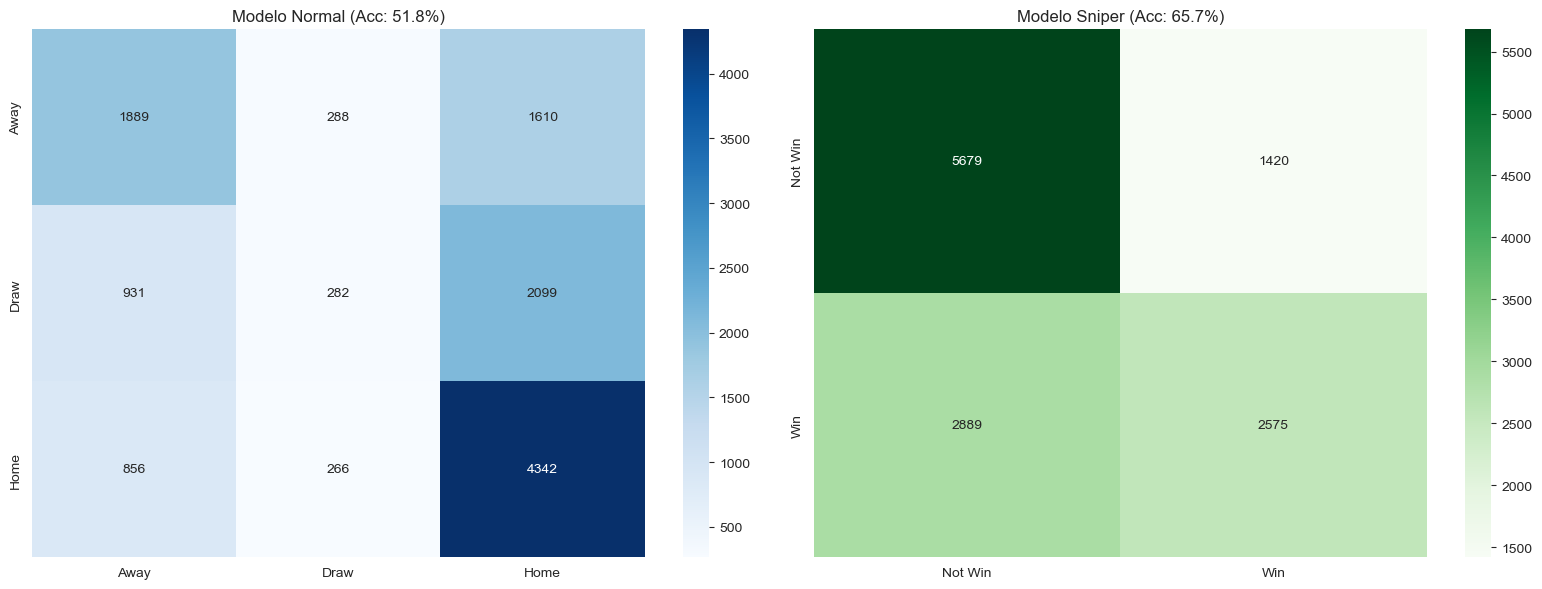


📊 RANKING DE IMPORTÂNCIA DAS FEATURES:


,Feature,Importance %
0,Imp_Away,24.92
1,Imp_Home,15.92
2,Imp_Draw,6.92
3,Home_Pos,1.48
4,EloDiff,1.42
5,HomeElo,1.35
6,Div_Code,1.33
7,Value_Ratio,1.32
8,Home_Avg_Points_5,1.30
9,Away_Avg_Corners_5,1.29


In [8]:
# 1. Configurar Figura para as Matrizes (apenas 2 gráficos agora)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Matriz Normal ---
preds_multi = model_multi.predict(X_test)
cm_multi = confusion_matrix(y_test, preds_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Away', 'Draw', 'Home'], yticklabels=['Away', 'Draw', 'Home'])
axes[0].set_title(f'Modelo Normal (Acc: {accuracy_score(y_test, preds_multi):.1%})')

# --- Plot 2: Matriz Sniper ---
y_test_win = (y_test == 2).astype(int)
preds_sniper = model_sniper.predict(X_test)
cm_sniper = confusion_matrix(y_test_win, preds_sniper)
sns.heatmap(cm_sniper, annot=True, fmt='d', cmap='Greens', ax=axes[1], 
            xticklabels=['Not Win', 'Win'], yticklabels=['Not Win', 'Win'])
axes[1].set_title(f'Modelo Sniper (Acc: {accuracy_score(y_test_win, preds_sniper):.1%})')

plt.tight_layout()
plt.show()

# 2. Tabela de Importância das Features (Todas)
print("\n📊 RANKING DE IMPORTÂNCIA DAS FEATURES:")
feature_imp = pd.DataFrame({
    'Feature': features, 
    'Importance': model_multi.feature_importances_
})

# Calcular percentagem e ordenar
feature_imp['Importance %'] = (feature_imp['Importance'] * 100).round(2)
feature_imp = feature_imp.sort_values('Importance', ascending=False).reset_index(drop=True)

# Mostrar a tabela (estilo Pandas)
# Ajustar opções para mostrar todas as linhas se forem muitas
pd.set_option('display.max_rows', None)
display(feature_imp[['Feature', 'Importance %']])
pd.reset_option('display.max_rows') # Repor o padrão depois

In [9]:
import joblib

# Selecionar apenas colunas necessárias para inferência (para o ficheiro ficar leve)
cols_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'Div', 'FTHG', 'FTAG', 'Home_Pos', 'Away_Pos', 
                'Home_Value', 'Away_Value'] + [c for c in df_ready.columns if 'Avg_' in c]

artifacts = {
    "model_multi": model_multi,
    "model_sniper": model_sniper,
    "model_shield": model_shield,
    "model_goals_h": xgb_goals_h,
    "model_goals_a": xgb_goals_a,
    "features": features,
    "le_div": le_div,
    "elos": current_elos,
    "history_df": df_ready[cols_to_keep].copy() # Histórico para lookups
}

print("💾 A guardar 'football_brain.pkl'...")
joblib.dump(artifacts, 'football_brain.pkl', compress=3)
print("✅ Cérebro guardado! Podes mover este ficheiro para a pasta do site.")

💾 A guardar 'football_brain.pkl'...
✅ Cérebro guardado! Podes mover este ficheiro para a pasta do site.


## 4. Previsão de Jogos Futuros
Função para inserir dados de jogos futuros e obter probabilidades da IA e análise de valor.

In [10]:
def predict_match_advanced(date_str, home_team, away_team, 
                           odd_h, odd_d, odd_a, 
                           division='E0', 
                           odd_1x=None, odd_12=None, odd_x2=None):
    
    match_date = pd.to_datetime(date_str)
    
    div_map = {
        'E0': 'Premier League 🇬🇧', 'E1': 'Championship 🇬🇧',
        'D1': 'Bundesliga 🇩🇪', 'D2': 'Bundesliga 2 🇩🇪',
        'SP1': 'La Liga 🇪🇸', 'SP2': 'La Liga 2 🇪🇸',
        'F1': 'Ligue 1 🇫🇷', 'F2': 'Ligue 2 🇫🇷',
        'I1': 'Serie A 🇮🇹', 'I2': 'Serie B 🇮🇹',
        'P1': 'Liga Portugal 🇵🇹',
        'N1': 'Eredivisie 🇳🇱', 'B1': 'Pro League 🇧🇪',
        'T1': 'Süper Lig 🇹🇷', 'G1': 'Super League 🇬🇷',
        'SC0': 'Premiership 🏴󠁧󠁢󠁳󠁣󠁴󠁿',
        'CL': 'Champions League 🇪🇺'
    }
    div_name = div_map.get(division, division)
    
    # --- 0. VALIDAÇÃO DE SEGURANÇA ---
    if division != 'CL':
        for team in [home_team, away_team]:
            team_games = df_ready[(df_ready['HomeTeam'] == team) | (df_ready['AwayTeam'] == team)].tail(20)
            if not team_games.empty:
                leagues = team_games[team_games['Div'] != 'CL']['Div'].value_counts()
                if not leagues.empty:
                    main_league = leagues.index[0]
                    if main_league != division:
                        print(f"❌ AVISO: {team} costuma jogar na {div_map.get(main_league, main_league)}, confirma a divisão!")

    print(f"\n🔮 PREVISÃO AVANÇADA ({div_name}): {home_team} vs {away_team} ({date_str})")
    print("=" * 100)
    
    past_data = df_ready[df_ready['Date'] < match_date].copy()
    if past_data.empty: 
        print("⚠️ Erro: Sem dados históricos suficientes.")
        return

    # --- 1. CONTEXTO & FEATURES ---
    def get_market_value(team):
        team_games = past_data[(past_data['HomeTeam'] == team) | (past_data['AwayTeam'] == team)]
        if not team_games.empty:
            last = team_games.iloc[-1]
            if last['HomeTeam'] == team: return last.get('Home_Value', 150)
            return last.get('Away_Value', 150)
        tier_1 = ['Man City', 'Real Madrid', 'Bayern Munich', 'Paris Saint Germain', 'Inter']
        if team in tier_1: return 800
        return 200

    def get_context(team):
        team_games = past_data[(past_data['HomeTeam'] == team) | (past_data['AwayTeam'] == team)]
        if team_games.empty: return 0.5, 10, 7
        last = team_games.iloc[-1]
        pos = last['Home_Pos'] if last['HomeTeam'] == team else last['Away_Pos']
        games = len(team_games)
        rest = (match_date - last['Date']).days
        if division == 'CL': motiv = 1.3
        else:
            motiv = 1.0
            if games > 28: 
                if pos > 6 and pos < 16: motiv = 0.5 
                else: motiv = 1.2 
        return motiv, pos, rest

    input_data = {}
    h_motiv, h_pos, h_rest = get_context(home_team)
    a_motiv, a_pos, a_rest = get_context(away_team)
    h_val = get_market_value(home_team)
    a_val = get_market_value(away_team)
    
    input_data['Home_Motiv'] = h_motiv; input_data['Away_Motiv'] = a_motiv
    input_data['Rest_Home'] = h_rest; input_data['Rest_Away'] = a_rest
    input_data['Home_Value'] = h_val; input_data['Away_Value'] = a_val
    input_data['Value_Ratio'] = np.log1p(h_val) - np.log1p(a_val)
    input_data['Is_Cup'] = 1 if division == 'CL' else 0
    input_data['Home_Fatigue'] = 1 if (h_val > 400 and h_rest < 4) else 0
    input_data['Away_Fatigue'] = 1 if (a_val > 400 and a_rest < 4) else 0
    
    h_elo = current_elos.get(home_team, 1500)
    a_elo = current_elos.get(away_team, 1500)
    input_data['HomeElo'] = h_elo; input_data['AwayElo'] = a_elo
    input_data['EloDiff'] = h_elo - a_elo
    input_data['Home_Pts'] = 0; input_data['Away_Pts'] = 0
    input_data['Home_Pos'] = h_pos; input_data['Away_Pos'] = a_pos
    
    try: input_data['Div_Code'] = le_div.transform([division])[0]
    except: input_data['Div_Code'] = 0
    
    input_data['Imp_Home'] = 1/odd_h; input_data['Imp_Draw'] = 1/odd_d; input_data['Imp_Away'] = 1/odd_a
    
    # Stats
    def fill_stats(team, prefix_h, prefix_a):
        games = past_data[(past_data['HomeTeam'] == team) | (past_data['AwayTeam'] == team)]
        if games.empty: return
        last = games.iloc[-1]
        for f in features:
            if 'Avg_' in f:
                try:
                    clean = ""
                    val = 0
                    if prefix_h in f: 
                        clean = f.replace(prefix_h, "")
                        col_name = f"Home_{clean}"
                        if col_name in last: val = last[col_name] if last['HomeTeam'] == team else last.get(f"Away_{clean}", 0)
                    elif prefix_a in f:
                        clean = f.replace(prefix_a, "")
                        col_name = f"Home_{clean}"
                        if col_name in last: val = last[col_name] if last['HomeTeam'] == team else last.get(f"Away_{clean}", 0)
                    if clean: input_data[f] = val
                except: pass 

    fill_stats(home_team, "Home_", "XX_IGNORE_XX")
    fill_stats(away_team, "XX_IGNORE_XX", "Away_")

    for f in features: 
        if f not in input_data: input_data[f] = df_ready[f].mean()

    # --- 2. EXECUÇÃO DOS MODELOS ---
    X_new = pd.DataFrame([input_data])[features]
    
    # Probabilidades Vitória (1X2)
    probs = model_multi.predict_proba(X_new)[0] 
    prob_a, prob_d, prob_h = probs[0], probs[1], probs[2]
    
    # Probabilidades Extra (Sniper/Shield)
    conf_win = model_sniper.predict_proba(X_new)[0][1]
    try: conf_shield = model_shield.predict_proba(X_new)[0][1] # Probabilidade de 1X
    except: conf_shield = prob_h + prob_d
    
    # Previsão de Golos (Poisson)
    exp_goals_h = xgb_goals_h.predict(X_new)[0]
    exp_goals_a = xgb_goals_a.predict(X_new)[0]
    
    # --- 3. CONSTRUÇÃO DA MATRIZ DE RESULTADOS EXATOS ---
    max_goals = 6
    score_matrix = np.zeros((max_goals, max_goals))
    for h in range(max_goals):
        for a in range(max_goals):
            prob_h_score = poisson.pmf(h, exp_goals_h)
            prob_a_score = poisson.pmf(a, exp_goals_a)
            score_matrix[h, a] = prob_h_score * prob_a_score

    # VISUALIZAÇÃO DA MATRIZ
    plt.figure(figsize=(7, 5))
    annot_matrix = np.array([[f"{val:.1%}" for val in row] for row in score_matrix])
    sns.heatmap(score_matrix, annot=annot_matrix, fmt='', cmap='magma', cbar=False,
                xticklabels=range(max_goals), yticklabels=range(max_goals),
                linewidths=.5, linecolor='black')
    plt.title(f"Probabilidade do Resultado: {home_team} vs {away_team}")
    plt.xlabel(f"Golos {away_team}")
    plt.ylabel(f"Golos {home_team}")
    plt.gca().invert_yaxis() 
    plt.show()

    # --- 4. RELATÓRIO E ANÁLISE DE VALOR ---
    print(f"📊 EXPECTED GOALS (IA):")
    print(f"   ⚽ {home_team}: {exp_goals_h:.2f} golos")
    print(f"   ⚽ {away_team}: {exp_goals_a:.2f} golos")
    
    # Resultado Exato mais provável
    max_idx = np.unravel_index(np.argmax(score_matrix, axis=None), score_matrix.shape)
    print(f"   🎯 Placar Mais Provável: {max_idx[0]} - {max_idx[1]} ({score_matrix[max_idx]:.1%})")
    print("-" * 100)
    
    print("💰 SCANNER DE MERCADO (Comparação de Percentagens):")
    opportunities = []

    def analyze(name, odd, prob, bet_type="Standard"):
        if not odd or odd <= 1: return
        implied_prob = 1 / odd 
        fair_odd = 1 / prob if prob > 0 else 99.0
        ev = (prob * odd) - 1
        
        # Classificação visual do valor
        if ev > 0.05: status = "💎 MUITO VALOR!"
        elif ev > 0: status = "✅ VALOR"
        elif ev > -0.05: status = "😐 JUSTO"
        else: status = "❌ FRACO"
        
        print(f"   • {name:<35} | Odd: {odd:.2f} ({implied_prob:.1%}) | IA: {fair_odd:.2f} ({prob:.1%}) | {status}")
        opportunities.append({"name": name, "odd": odd, "prob": prob, "ev": ev})

    # 1. Mercados Principais (1X2)
    analyze(f"Vitoria {home_team}", odd_h, prob_h)
    analyze("Empate", odd_d, prob_d)
    analyze(f"Vitoria {away_team}", odd_a, prob_a)
    
    # 2. Dupla Chance (Cálculo Híbrido com Shield)
    # Prob(1X) = Média entre (Prob(H)+Prob(D)) e Modelo Shield
    prob_1x_final = ( (prob_h + prob_d) + conf_shield ) / 2
    prob_x2_final = prob_a + prob_d # O Shield foca-se em 1X, o X2 calculamos aritmeticamente
    prob_12_final = prob_h + prob_a
    
    if odd_1x: analyze(f"DC 1X ({home_team} ou Empate)", odd_1x, prob_1x_final)
    if odd_x2: analyze(f"DC X2 ({away_team} ou Empate)", odd_x2, prob_x2_final)
    if odd_12: analyze(f"DC 12 ({home_team} ou {away_team})", odd_12, prob_12_final)

    print("-" * 100)
    
    # --- 5. VEREDICTO FINAL ---
    opportunities.sort(key=lambda x: x['ev'], reverse=True)
    best_value = opportunities[0]
    
    most_likely = sorted(opportunities, key=lambda x: x['prob'], reverse=True)[0]
    
    print(f"🏆 ESCOLHA RACIONAL (Valor Matemático):")
    print(f"   👉 {best_value['name']}")
    print(f"   💵 Odd: {best_value['odd']:.2f}")
    print(f"   📈 EV: {best_value['ev']:.1%} (Lucro esperado a longo prazo)")
    
    print(f"\n🎲 RESULTADO MAIS PROVÁVEL (Segurança):")
    if most_likely['name'] == best_value['name']:
        print("   (Igual à Escolha Racional - O melhor dos dois mundos!)")
    else:
        print(f"   👉 {most_likely['name']}")
        print(f"   🛡️ Confiança: {most_likely['prob']:.1%}")
        if most_likely['ev'] < 0:
            print(f"   ⚠️ Nota: É provável, mas a Odd está baixa (EV Negativo). Não compensa o risco/retorno.")

❌ AVISO: Porto costuma jogar na Liga Portugal 🇵🇹, confirma a divisão!

🔮 PREVISÃO AVANÇADA (EL): Porto vs Malmo (2025-12-11)


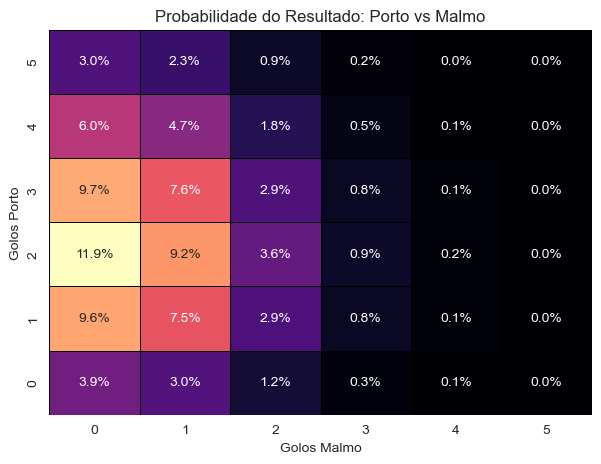

📊 EXPECTED GOALS (IA):
   ⚽ Porto: 2.46 golos
   ⚽ Malmo: 0.78 golos
   🎯 Placar Mais Provável: 2 - 0 (11.9%)
----------------------------------------------------------------------------------------------------
💰 SCANNER DE MERCADO (Comparação de Percentagens):
   • Vitoria Porto                       | Odd: 1.20 (83.3%) | IA: 1.24 (80.5%) | 😐 JUSTO
   • Empate                              | Odd: 7.00 (14.3%) | IA: 7.29 (13.7%) | 😐 JUSTO
   • Vitoria Malmo                       | Odd: 12.00 (8.3%) | IA: 17.37 (5.8%) | ❌ FRACO
   • DC 1X (Porto ou Empate)             | Odd: 1.05 (95.2%) | IA: 1.06 (94.3%) | 😐 JUSTO
   • DC X2 (Malmo ou Empate)             | Odd: 4.33 (23.1%) | IA: 5.13 (19.5%) | ❌ FRACO
   • DC 12 (Porto ou Malmo)              | Odd: 1.10 (90.9%) | IA: 1.16 (86.3%) | ❌ FRACO
----------------------------------------------------------------------------------------------------
🏆 ESCOLHA RACIONAL (Valor Matemático):
   👉 DC 1X (Porto ou Empate)
   💵 Odd: 1.05
   📈 EV: -1.0%

In [11]:
predict_match_advanced('2025-12-11', 'Porto', 'Malmo', 
                       odd_h=1.20, odd_d=7, odd_a=12, 
                       division='EL',
                       odd_1x=1.05, odd_12=1.10, odd_x2=4.33)


🔮 PREVISÃO AVANÇADA (La Liga 🇪🇸): Real Sociedad vs Girona (2025-12-11)


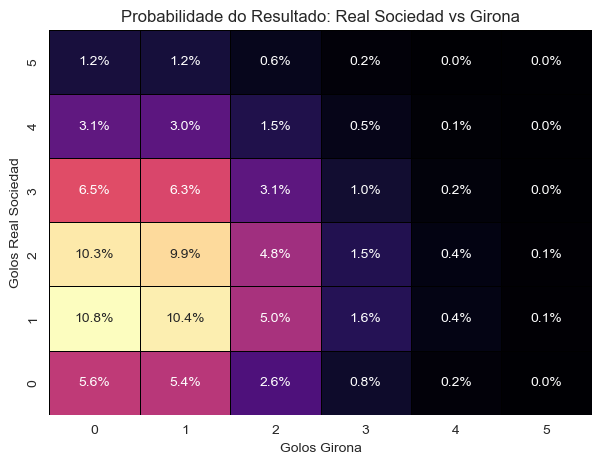

📊 EXPECTED GOALS (IA):
   ⚽ Real Sociedad: 1.91 golos
   ⚽ Girona: 0.97 golos
   🎯 Placar Mais Provável: 1 - 0 (10.8%)
----------------------------------------------------------------------------------------------------
💰 SCANNER DE MERCADO (Comparação de Percentagens):
   • Vitoria Real Sociedad               | Odd: 1.73 (57.8%) | IA: 1.81 (55.2%) | 😐 JUSTO
   • Empate                              | Odd: 3.90 (25.6%) | IA: 3.73 (26.8%) | ✅ VALOR
   • Vitoria Girona                      | Odd: 4.50 (22.2%) | IA: 5.56 (18.0%) | ❌ FRACO
   • DC 1X (Real Sociedad ou Empate)     | Odd: 1.18 (84.7%) | IA: 1.23 (81.6%) | 😐 JUSTO
   • DC X2 (Girona ou Empate)            | Odd: 2.00 (50.0%) | IA: 2.23 (44.8%) | ❌ FRACO
   • DC 12 (Real Sociedad ou Girona)     | Odd: 1.25 (80.0%) | IA: 1.37 (73.2%) | ❌ FRACO
----------------------------------------------------------------------------------------------------
🏆 ESCOLHA RACIONAL (Valor Matemático):
   👉 Empate
   💵 Odd: 3.90
   📈 EV: 4.7% (Lucro e

In [12]:
predict_match_advanced('2025-12-11', 'Real Sociedad', 'Girona', 
                       odd_h=1.73, odd_d=3.90, odd_a=4.50, 
                       division='SP1',
                       odd_1x=1.18, odd_12=1.25, odd_x2=2)


🔮 PREVISÃO AVANÇADA (Champions League 🇪🇺): Atalanta vs Chelsea (2025-12-09)


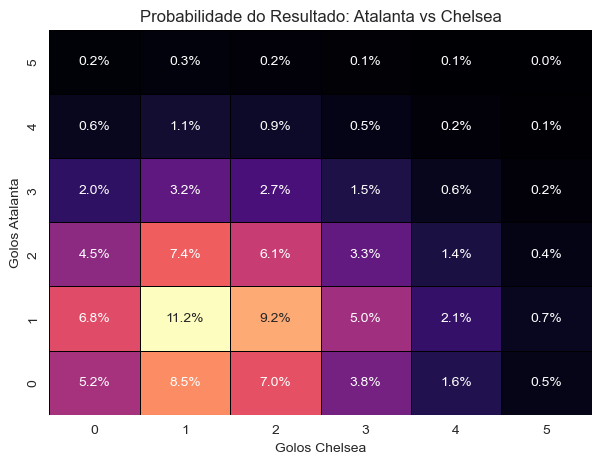

📊 EXPECTED GOALS (IA):
   ⚽ Atalanta: 1.31 golos
   ⚽ Chelsea: 1.64 golos
   🎯 Placar Mais Provável: 1 - 1 (11.2%)
----------------------------------------------------------------------------------------------------
💰 SCANNER DE MERCADO (Comparação de Percentagens):
   • Vitoria Atalanta                    | Odd: 3.10 (32.3%) | IA: 3.60 (27.8%) | ❌ FRACO
   • Empate                              | Odd: 3.60 (27.8%) | IA: 3.38 (29.6%) | 💎 MUITO VALOR!
   • Vitoria Chelsea                     | Odd: 2.20 (45.5%) | IA: 2.35 (42.6%) | ❌ FRACO
   • DC 1X (Atalanta ou Empate)          | Odd: 1.70 (58.8%) | IA: 1.80 (55.6%) | ❌ FRACO
   • DC X2 (Chelsea ou Empate)           | Odd: 1.29 (77.5%) | IA: 1.38 (72.2%) | ❌ FRACO
   • DC 12 (Atalanta ou Chelsea)         | Odd: 1.30 (76.9%) | IA: 1.42 (70.4%) | ❌ FRACO
----------------------------------------------------------------------------------------------------
🏆 ESCOLHA RACIONAL (Valor Matemático):
   👉 Empate
   💵 Odd: 3.60
   📈 EV: 6.5% (Lucr

In [13]:
predict_match_advanced('2025-12-09', 'Atalanta', 'Chelsea', 
                       odd_h=3.10, odd_d=3.60, odd_a=2.20, 
                       division='CL',
                       odd_1x=1.70, odd_12=1.30, odd_x2=1.29)


🔮 PREVISÃO AVANÇADA (Champions League 🇪🇺): PSV vs Atletico Madrid (2025-12-09)


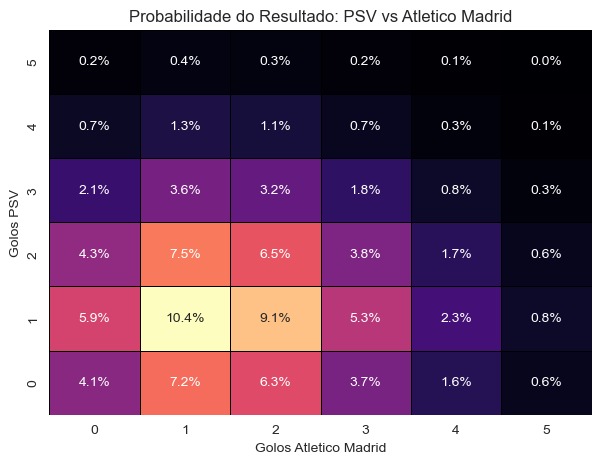

📊 EXPECTED GOALS (IA):
   ⚽ PSV: 1.44 golos
   ⚽ Atletico Madrid: 1.75 golos
   🎯 Placar Mais Provável: 1 - 1 (10.4%)
----------------------------------------------------------------------------------------------------
💰 SCANNER DE MERCADO (Comparação de Percentagens):
   • Vitoria PSV                         | Odd: 2.88 (34.7%) | IA: 3.17 (31.5%) | ❌ FRACO
   • Empate                              | Odd: 3.80 (26.3%) | IA: 2.84 (35.2%) | 💎 MUITO VALOR!
   • Vitoria Atletico Madrid             | Odd: 2.20 (45.5%) | IA: 3.00 (33.3%) | ❌ FRACO
   • DC 1X (PSV ou Empate)               | Odd: 1.67 (59.9%) | IA: 1.58 (63.3%) | 💎 MUITO VALOR!
   • DC X2 (Atletico Madrid ou Empate)   | Odd: 1.25 (80.0%) | IA: 1.46 (68.5%) | ❌ FRACO
   • DC 12 (PSV ou Atletico Madrid)      | Odd: 1.40 (71.4%) | IA: 1.54 (64.8%) | ❌ FRACO
----------------------------------------------------------------------------------------------------
🏆 ESCOLHA RACIONAL (Valor Matemático):
   👉 Empate
   💵 Odd: 3.80
   📈 EV: 

In [14]:
predict_match_advanced('2025-12-09', 'PSV', 'Atletico Madrid', 
                       odd_h=2.88, odd_d=3.80, odd_a=2.20, 
                       division='CL',
                       odd_1x=1.67, odd_12=1.40, odd_x2=1.25)


🔮 PREVISÃO AVANÇADA (Champions League 🇪🇺): Barcelona vs Frankfurt (2025-12-09)


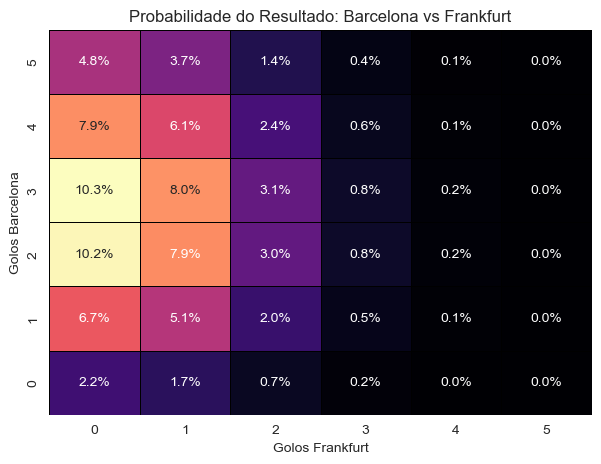

📊 EXPECTED GOALS (IA):
   ⚽ Barcelona: 3.05 golos
   ⚽ Frankfurt: 0.77 golos
   🎯 Placar Mais Provável: 3 - 0 (10.3%)
----------------------------------------------------------------------------------------------------
💰 SCANNER DE MERCADO (Comparação de Percentagens):
   • Vitoria Barcelona                   | Odd: 1.14 (87.7%) | IA: 1.19 (84.2%) | 😐 JUSTO
   • Empate                              | Odd: 9.00 (11.1%) | IA: 8.82 (11.3%) | ✅ VALOR
   • Vitoria Frankfurt                   | Odd: 13.00 (7.7%) | IA: 22.35 (4.5%) | ❌ FRACO
   • DC 1X (Barcelona ou Empate)         | Odd: 1.04 (96.2%) | IA: 1.05 (95.2%) | 😐 JUSTO
   • DC X2 (Frankfurt ou Empate)         | Odd: 5.50 (18.2%) | IA: 6.32 (15.8%) | ❌ FRACO
   • DC 12 (Barcelona ou Frankfurt)      | Odd: 1.07 (93.5%) | IA: 1.13 (88.7%) | ❌ FRACO
----------------------------------------------------------------------------------------------------
🏆 ESCOLHA RACIONAL (Valor Matemático):
   👉 Empate
   💵 Odd: 9.00
   📈 EV: 2.1% (Lucro es

In [15]:
predict_match_advanced('2025-12-09', 'Barcelona', 'Frankfurt', 
                       odd_h=1.14, odd_d=9.00, odd_a=13.0, 
                       division='CL',
                       odd_1x=1.04, odd_12=1.07, odd_x2=5.50)